This is an example notebook and is not designed to reproduce any particular result. Feel free to adapt it for your own use.

In [1]:
#import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
#os.chdir(pybamm.__path__[0]+'/..')
# pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "thermal": "lumped",
        "SEI": "solvent-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible"
    }
)

In [3]:
param = pybamm.ParameterValues("OKane2023")
param.update({"Upper voltage cut-off [V]": 4.21})
param.update({"Lower voltage cut-off [V]": 2.49})
# Latest attempt at balancing; adjust as required
param.update({"Maximum concentration in negative electrode [mol.m-3]": 32544})
param.update({"Maximum concentration in positive electrode [mol.m-3]": 56598})
param.update({"Initial concentration in negative electrode [mol.m-3]": 28162})
param.update({"Initial concentration in positive electrode [mol.m-3]": 15281})
# Override SEI thickness dependence of lithium plating
param.update({"Dead lithium decay rate [s-1]": 1E-6})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-10})

In [5]:
# C/10 discharge run at start and after every 100 ageing cycles 
exp = pybamm.Experiment(
    [("Hold at 4.2V until C/100", "Rest for 4 hours (5 minute period)"),] +  # Formation "cycle" run once only
    [("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    [("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    [("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    [("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    [("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    [("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    #[("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    #[("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    #[("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    #[("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    #[("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    #[("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    #[("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    #[("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    #[("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    #[("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    #[("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    #[("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    #[("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] +
    #[("Discharge at 1C until 2.5V", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),] * 100 +
    [("Discharge at C/10 until 2.5V (5 minute period)", "Charge at 0.3C until 4.2V (5 minute period)", "Hold at 4.2V until C/100 (5 minute period)"),]
)

In [6]:
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 100,  # negative particle
    "r_p": 30,  # positive particle
}

In [7]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts,
)
solution1 = sim1.solve(
    save_at_cycles=[1,2,103,204,305]  # Only save C/10 evaluation cycles to save RAM
    #save_at_cycles=[1,2,103,204,305,406,507,608,709,810,911,1012]  # Only save C/10 evaluation cycles to save RAM
)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

At t = 0.0051207 and h = 9.1634e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00477844 and h = 2.30603e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00477844 and h = 5.3412e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00443771 and h = 1.137e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00443771 and h = 8.14432e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00409828 and h = 1.25452e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00409828 and h = 1.97208e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00375999 and h = 9.63571e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00375986 and h = 7.31702e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00342273 and h = 9.02071e-17, the corrector convergence failed repeat

At t = 0.00336746 and h = 4.70404e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00336746 and h = 2.08559e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00300241 and h = 1.06206e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00300241 and h = 1.38866e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00263642 and h = 7.82273e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00263642 and h = 1.16496e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00520796 and h = 5.63979e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00483595 and h = 1.3627e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00483595 and h = 5.13025e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00233595 and h = 1.31284e-16, the corrector convergence failed re

At t = 0.00318405 and h = 3.06863e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00318405 and h = 9.64815e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00271269 and h = 2.481e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00271269 and h = 6.31793e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0022386 and h = 3.09764e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0022386 and h = 7.92928e-24, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00223859 and h = 1.3335e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00520891 and h = 2.96285e-23, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0047173 and h = 1.60794e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00471731 and h = 1.04984e-19, the corrector convergence failed repeate

At t = 0.00454062 and h = 1.29035e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00454067 and h = 2.35162e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00204066 and h = 2.81363e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00382944 and h = 6.69596e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00382944 and h = 1.17369e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00311068 and h = 3.40981e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00311067 and h = 1.64242e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00238425 and h = 8.1603e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00238425 and h = 5.83875e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00238425 and h = 7.45013e-17, the corrector convergence failed re

running time: 13840.605295493995s


In [8]:
path = '/mnt/c/Users/sokane/pybamm_data/OKane2023_prelim/'

In [12]:
N_cycles = solution1.summary_variables["Cycle number"]
Q_sei = solution1.summary_variables["Loss of capacity to SEI [A.h]"]
Q_sei_cracks = solution1.summary_variables["Loss of capacity to SEI on cracks [A.h]"]
Q_plating = solution1.summary_variables["Loss of capacity to lithium plating [A.h]"]
Q_side = solution1.summary_variables["Total capacity lost to side reactions [A.h]"]
LAM_neg = solution1.summary_variables["Loss of active material in negative electrode [%]"]
LAM_pos = solution1.summary_variables["Loss of active material in positive electrode [%]"]

In [ ]:
len(solution1.cycles)

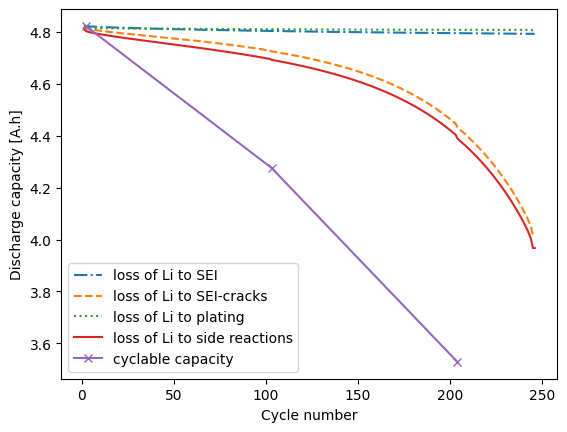

In [14]:
N_cycles_RPT = []
N_cycles_RPT.append(2)
Q_throughput_RPT = []
Q_dis_RPT = []
Qdis = solution1.cycles[1].steps[0]["Discharge capacity [A.h]"].entries
Qdis_delta = Qdis[-1] - Qdis[0]
Q_dis_RPT.append(Qdis_delta)
Qt = solution1.cycles[1].steps[0]["Throughput capacity [A.h]"].entries
Q_throughput_RPT.append(Qt[-1])
for i in range(2):
    Qdis = solution1.cycles[101*i+102].steps[0]["Discharge capacity [A.h]"].entries
    Qdis_delta = Qdis[-1] - Qdis[0]
    Q_dis_RPT.append(Qdis_delta)
    Qt = solution1.cycles[101*i+102].steps[0]["Throughput capacity [A.h]"].entries
    Q_throughput_RPT.append(Qt[-1])
    N_cycles_RPT.append(101*i+103)
plt.figure()
plt.plot(N_cycles, Q_dis_RPT[0]-Q_sei, label="loss of Li to SEI", linestyle="dashdot")
plt.plot(N_cycles, Q_dis_RPT[0]-Q_sei_cracks, label="loss of Li to SEI-cracks", linestyle="dashed")
plt.plot(N_cycles, Q_dis_RPT[0]-Q_plating, label="loss of Li to plating", linestyle="dotted")
plt.plot(N_cycles, Q_dis_RPT[0]-Q_side, label="loss of Li to side reactions")
plt.plot(N_cycles_RPT, Q_dis_RPT, label="cyclable capacity", marker="x")
plt.xlabel("Cycle number")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()
filename = path+'Nonlinear_diffusion_v2.pdf'
plt.savefig(filename,bbox_inches='tight')
plt.show()

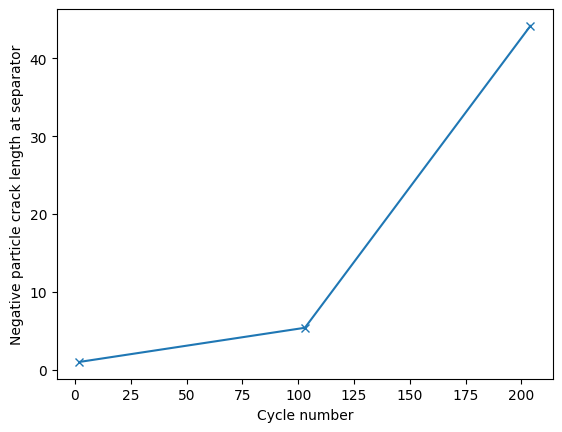

In [20]:
l_cr = []
lcr = solution1.cycles[1]["Negative particle crack length"].entries[-1,-1]
l_cr.append(lcr)
for i in range(2):
    lcr = solution1.cycles[101*i+102]["Negative particle crack length"].entries[-1,-1]
    l_cr.append(lcr)
plt.figure()
plt.plot(N_cycles_RPT,l_cr,marker="x")
plt.xlabel("Cycle number")
plt.ylabel("Negative particle crack length at separator")
plt.show()

In [ ]:
Qdis_zero = solution1.cycles[2]["Discharge capacity [A.h]"].entries
Vdis_zero = solution1.cycles[2]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[2]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[2]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[2]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[2]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[2]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[2]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[2]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[2]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[2]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[2]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[2]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[2]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[2]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[2]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[2]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[2]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[2]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[2]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[2]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[2]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[2]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[2]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[2]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[2]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[2]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[2]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[2]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[2]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[2]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[2]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[2]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[2]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[2]["Positive electrolyte concentration"].entries[-1,:]
M_zero = np.array([Qdis_zero,Vdis_zero,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_zero = path+'FullyCoupled_reference_zero.txt'
np.savetxt(filename_zero,M_zero,delimiter=",")
Qdis_first = solution1.cycles[5].steps[0]["Discharge capacity [A.h]"].entries
Vdis_first = solution1.cycles[5].steps[0]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[5].steps[0]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[5].steps[0]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[5].steps[0]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[5].steps[0]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[5].steps[0]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[5].steps[0]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[5].steps[0]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[5].steps[0]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[5].steps[0]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[5].steps[0]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[5].steps[0]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[5].steps[0]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[5].steps[0]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[5].steps[0]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[5].steps[0]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[5].steps[0]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[5].steps[0]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[5].steps[0]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[5].steps[0]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[5].steps[0]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[5].steps[0]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[5].steps[0]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[5].steps[0]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[5].steps[0]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[5].steps[0]["Positive electrolyte concentration"].entries[-1,:]
M_first = np.array([Qdis_first,Vdis_first,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_first = path+'FullyCoupled_reference_first.txt'
np.savetxt(filename_first,M_first,delimiter=",")
Qdis_last = solution1.cycles[total_cycles+4].steps[0]["Discharge capacity [A.h]"].entries
Vdis_last = solution1.cycles[total_cycles+4].steps[0]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[total_cycles+4].steps[0]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[total_cycles+4].steps[0]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[total_cycles+4].steps[0]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[total_cycles+4].steps[0]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[total_cycles+4].steps[0]["Positive electrolyte concentration"].entries[-1,:]
M_last = np.array([Qdis_last,Vdis_last,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_last = path+'FullyCoupled_reference_last.txt'
np.savetxt(filename_last,M_last,delimiter=",")
Qdis_eval = solution1.cycles[total_cycles+5]["Discharge capacity [A.h]"].entries
Vdis_eval = solution1.cycles[total_cycles+5]["Terminal voltage [V]"].entries
eta_SEI_avg = solution1.cycles[total_cycles+5]["X-averaged SEI film overpotential [V]"].entries
eta_SEI_sep = solution1.cycles[total_cycles+5]["SEI film overpotential [V]"].entries[-1,:]
eta_SEI_CC = solution1.cycles[total_cycles+5]["SEI film overpotential [V]"].entries[0,:]
cs_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative particle surface concentration"].entries
cs_neg_sep = solution1.cycles[total_cycles+5]["Negative particle surface concentration"].entries[-1,:]
cs_neg_CC = solution1.cycles[total_cycles+5]["Negative particle surface concentration"].entries[0,:]
cs_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive particle surface concentration"].entries
cs_pos_sep = solution1.cycles[total_cycles+5]["Positive particle surface concentration"].entries[0,:]
cs_pos_CC = solution1.cycles[total_cycles+5]["Positive particle surface concentration"].entries[-1,:]
U_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrode open circuit potential [V]"].entries
U_neg_sep = solution1.cycles[total_cycles+5]["Negative electrode open circuit potential [V]"].entries[-1,:]
U_neg_CC = solution1.cycles[total_cycles+5]["Negative electrode open circuit potential [V]"].entries[0,:]
U_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrode open circuit potential [V]"].entries
U_pos_sep = solution1.cycles[total_cycles+5]["Positive electrode open circuit potential [V]"].entries[0,:]
U_pos_CC = solution1.cycles[total_cycles+5]["Positive electrode open circuit potential [V]"].entries[-1,:]
phis_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrode potential [V]"].entries
phis_neg_sep = solution1.cycles[total_cycles+5]["Negative electrode potential [V]"].entries[-1,:]
phis_neg_CC = solution1.cycles[total_cycles+5]["Negative electrode potential [V]"].entries[0,:]
phis_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrode potential [V]"].entries
phis_pos_sep = solution1.cycles[total_cycles+5]["Positive electrode potential [V]"].entries[0,:]
phis_pos_CC = solution1.cycles[total_cycles+5]["Positive electrode potential [V]"].entries[-1,:]
phie_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrolyte potential [V]"].entries
phie_neg_sep = solution1.cycles[total_cycles+5]["Negative electrolyte potential [V]"].entries[-1,:]
phie_neg_CC = solution1.cycles[total_cycles+5]["Negative electrolyte potential [V]"].entries[0,:]
phie_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrolyte potential [V]"].entries
phie_pos_sep = solution1.cycles[total_cycles+5]["Positive electrolyte potential [V]"].entries[0,:]
phie_pos_CC = solution1.cycles[total_cycles+5]["Positive electrolyte potential [V]"].entries[-1,:]
ce_neg_avg = solution1.cycles[total_cycles+5]["X-averaged negative electrolyte concentration"].entries
ce_neg_sep = solution1.cycles[total_cycles+5]["Negative electrolyte concentration"].entries[-1,:]
ce_neg_CC = solution1.cycles[total_cycles+5]["Negative electrolyte concentration"].entries[0,:]
ce_pos_avg = solution1.cycles[total_cycles+5]["X-averaged positive electrolyte concentration"].entries
ce_pos_sep = solution1.cycles[total_cycles+5]["Positive electrolyte concentration"].entries[0,:]
ce_pos_CC = solution1.cycles[total_cycles+5]["Positive electrolyte concentration"].entries[-1,:]
M_eval = np.array([Qdis_eval,Vdis_eval,eta_SEI_avg,eta_SEI_sep,eta_SEI_CC,
                    cs_neg_avg,cs_neg_sep,cs_neg_CC,cs_pos_avg,cs_pos_sep,cs_pos_CC,
                    U_neg_avg,U_neg_sep,U_neg_CC,U_pos_avg,U_pos_sep,U_pos_CC,
                    phis_neg_avg,phis_neg_sep,phis_neg_CC,phis_pos_avg,phis_pos_sep,phis_pos_CC,
                    phie_neg_avg,phie_neg_sep,phie_neg_CC,phie_pos_avg,phie_pos_sep,phie_pos_CC,
                    ce_neg_avg,ce_neg_sep,ce_neg_CC,ce_pos_avg,ce_pos_sep,ce_pos_CC,
])
filename_eval = path+'FullyCoupled_reference_eval.txt'
np.savetxt(filename_eval,M_eval,delimiter=",")

In [ ]:
fig, ax = plt.subplots()
ax.plot(Qdis_zero,Vdis_zero,label="0.1C discharge at start")
ax.plot(Qdis_first,Vdis_first,label="First discharge",linestyle="dashed")
ax.plot(Qdis_last,Vdis_last,label="Last discharge",linestyle="dashdot")
ax.plot(Qdis_eval,Vdis_eval,label="0.1C discharge at end",linestyle="dotted")
ax.set_xlabel("Discharge capacity [A.h]")
ax.set_ylabel("Terminal voltage [V]")
ax.legend()
filename = path+"FullyCoupled_ZFLE.pdf"
plt.savefig(filename)
plt.show()